In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

##  Probability and Statistics

###  Introduction to Uncertainty in Machine Learning

Machine learning fundamentally deals with uncertainty in various forms:

- In **supervised learning**, we predict unknown targets given known features:
  - Predicting most likely values
  - Predicting values with minimal expected distance from targets
  - Quantifying uncertainty (e.g., probability of patient heart attacks)

- In **unsupervised learning**, we assess the likelihood of observations within populations

- In **reinforcement learning**, we reason about:
  - Expected environmental changes
  - Anticipated rewards for different actions

### Probability: Mathematical Framework for Uncertainty

Probability theory provides tools for reasoning under uncertainty through probabilistic models. Two main interpretations exist:

1. **Frequentist Probability**:
   - Describes frequencies of repeatable events
   - Limited to repeatable phenomena
   - Example: coin toss probabilities

2. **Bayesian Probability**:
   - Broader formalization of uncertainty reasoning
   - Distinguished by:
     - Assigns belief degrees to non-repeatable events (e.g., $P(\text{moon is made of cheese})$)
     - Embraces subjectivity while providing unambiguous belief update rules
     - Allows different prior beliefs among individuals

### Statistical Reasoning

Statistics enables reverse reasoning:
- Starts with data collection and organization
- Infers characteristics of data-generating processes
- Identifies patterns that might generalize to broader populations

```python
%matplotlib inline
import random
import torch
from torch.distributions.multinomial import Multinomial
from d2l import torch as d2l
```

##  Coin Tossing: A Basic Probability Example

Consider a coin toss experiment where we want to quantify $P(\text{heads})$ vs $P(\text{tails})$.

For a fair coin:
- Both outcomes are equally likely
- For $n$ tosses:
  - Expected heads fraction = Expected tails fraction
  - Mathematically: for $n_h$ heads and $n_t = (n - n_h)$ tails
  - By symmetry: each outcome $(n_h, n_t)$ pairs with equally likely $(n_t, n_h)$
  - Therefore: $E[\frac{n_h}{n}] = E[\frac{n_t}{n}] = \frac{1}{2}$

Note: For large $n$ (e.g., $n = 1,000,000$), exact equality $n_h = n_t$ is extremely unlikely in any single trial.

$\blacksquare$

## 2.6.2 Formal Probability and Statistical Estimation

### Probability vs Statistics

A probability (like $\frac{1}{2}$ for a fair coin) represents:
- A score between 0 and 1 assigned to events
- Denoted as $P(\text{event})$, e.g., $P(\text{heads})$
- Boundary cases:
  - $P(\text{event}) = 1$: absolute certainty (e.g., two-headed coin)
  - $P(\text{event}) = 0$: impossibility (e.g., two-tailed coin)

Statistical quantities (like $\frac{n_h}{n}$ and $\frac{n_t}{n}$) differ from probabilities:
- Probabilities: theoretical quantities underlying data generation
- Statistics: empirical quantities computed from observed data
- Estimators: special statistics designed to estimate probability parameters
  - When consistent, estimates converge to true probabilities
  - Inferred probabilities inform future expectations

### Empirical Investigation

To investigate unknown $P(\text{heads})$:
1. Collect data (sampling)
2. Design estimator (e.g., $\frac{\text{observed heads}}{\text{total tosses}}$)

### Simulation Examples

Basic coin flip simulation using Python's random:

```python
num_tosses = 100
heads = sum([random.random() > 0.5 for _ in range(100)])
tails = num_tosses - heads
print("heads, tails: ", [heads, tails])
# Output example: heads, tails: [48, 52]
```

Using PyTorch's Multinomial distribution:

```python
fair_probs = torch.tensor([0.5, 0.5])
# 100 tosses
Multinomial(100, fair_probs).sample()
# Output example: tensor([44., 56.])

# Frequencies
Multinomial(100, fair_probs).sample() / 100
# Output example: tensor([0.5300, 0.4700])

# Large sample (10000 tosses)
counts = Multinomial(10000, fair_probs).sample()
counts / 10000
# Output example: tensor([0.4970, 0.5030])
```

### Law of Large Numbers Visualization

```python
# Generate cumulative estimates
counts = Multinomial(1, fair_probs).sample((10000,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
estimates = estimates.numpy()

# Plotting
d2l.set_figsize((4.5, 3.5))
d2l.plt.plot(estimates[:, 0], label=("P(coin=heads)"))
d2l.plt.plot(estimates[:, 1], label=("P(coin=tails)"))
d2l.plt.axhline(y=0.5, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Samples')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();
```

### Key Theoretical Results

1. **Law of Large Numbers**: 
   - For repeated events, estimates converge to true probabilities as sample size increases

2. **Central Limit Theorem**:
   - For many scenarios, estimation errors decrease at rate $\frac{1}{\sqrt{n}}$
   - $n$ = sample size

### Advanced Statistical Questions

The study raises deeper statistical questions:
- Convergence rate analysis
- Incorporation of prior information (e.g., data from similar coins)
- Optimal sample size determination
- Confidence interval estimation
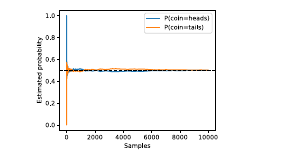

$\blacksquare$

In [1]:
import random
import torch
import matplotlib.pyplot as plt
from torch.distributions.multinomial import Multinomial
import numpy as np

class CoinTossExperiment:
    def __init__(self, prob_heads=0.5):
        """
        Initialize coin toss experiment.
        
        Args:
            prob_heads (float): Probability of heads (default: 0.5 for fair coin)
        """
        self.prob_heads = prob_heads
        self.probs = torch.tensor([prob_heads, 1 - prob_heads])
        
    def basic_toss(self, num_tosses):
        """
        Simulate coin tosses using basic Python random.
        
        Args:
            num_tosses (int): Number of tosses to simulate
            
        Returns:
            tuple: (heads count, tails count)
        """
        heads = sum([random.random() > (1 - self.prob_heads) for _ in range(num_tosses)])
        return heads, num_tosses - heads
    
    def multinomial_toss(self, num_tosses):
        """
        Simulate coin tosses using PyTorch Multinomial.
        
        Args:
            num_tosses (int): Number of tosses to simulate
            
        Returns:
            tensor: Counts of [heads, tails]
        """
        return Multinomial(num_tosses, self.probs).sample()
    
    def estimate_probability(self, num_tosses):
        """
        Estimate probabilities from tosses.
        
        Args:
            num_tosses (int): Number of tosses to simulate
            
        Returns:
            tensor: Estimated probabilities [P(heads), P(tails)]
        """
        counts = self.multinomial_toss(num_tosses)
        return counts / num_tosses
    
    def convergence_experiment(self, max_tosses, num_experiments=1):
        """
        Run convergence experiment.
        
        Args:
            max_tosses (int): Maximum number of tosses per experiment
            num_experiments (int): Number of experiments to run
            
        Returns:
            numpy.ndarray: Array of estimates over time for each experiment
        """
        all_estimates = []
        
        for _ in range(num_experiments):
            counts = Multinomial(1, self.probs).sample((max_tosses,))
            cum_counts = counts.cumsum(dim=0)
            estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
            all_estimates.append(estimates.numpy())
            
        return np.array(all_estimates)
    
    def plot_convergence(self, max_tosses=10000, num_experiments=1):
        """
        Plot probability convergence over multiple tosses.
        
        Args:
            max_tosses (int): Maximum number of tosses
            num_experiments (int): Number of experiments to plot
        """
        estimates = self.convergence_experiment(max_tosses, num_experiments)
        
        plt.figure(figsize=(10, 6))
        for i in range(num_experiments):
            plt.plot(estimates[i, :, 0], alpha=0.5, label=f'Experiment {i+1} - P(heads)')
        
        plt.axhline(y=self.prob_heads, color='black', linestyle='dashed', label='True P(heads)')
        plt.xlabel('Number of Tosses')
        plt.ylabel('Estimated Probability')
        plt.title('Convergence of Probability Estimates')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def error_analysis(self, max_tosses=10000, num_experiments=100):
        """
        Analyze estimation error vs sample size.
        
        Args:
            max_tosses (int): Maximum number of tosses
            num_experiments (int): Number of experiments for error analysis
            
        Returns:
            tuple: (sample_sizes, mean_errors, std_errors)
        """
        sample_sizes = np.logspace(1, np.log10(max_tosses), 50).astype(int)
        errors = np.zeros((len(sample_sizes), num_experiments))
        
        for i, n in enumerate(sample_sizes):
            for j in range(num_experiments):
                estimate = self.estimate_probability(n)[0].item()
                errors[i, j] = abs(estimate - self.prob_heads)
                
        mean_errors = errors.mean(axis=1)
        std_errors = errors.std(axis=1)
        
        return sample_sizes, mean_errors, std_errors

# Example usage
def run_demonstration():
    # Create experiment instance
    experiment = CoinTossExperiment(prob_heads=0.5)
    
    # Basic tosses
    print("Basic coin toss (100 tosses):")
    heads, tails = experiment.basic_toss(100)
    print(f"Heads: {heads}, Tails: {tails}")
    
    # Multinomial tosses
    print("\nMultinomial toss (100 tosses):")
    counts = experiment.multinomial_toss(100)
    print(f"Counts: {counts}")
    
    # Probability estimation
    print("\nProbability estimation (1000 tosses):")
    probs = experiment.estimate_probability(1000)
    print(f"P(heads): {probs[0]:.3f}, P(tails): {probs[1]:.3f}")
    
    # Plot convergence
    print("\nPlotting convergence for 3 experiments...")
    experiment.plot_convergence(max_tosses=10000, num_experiments=3)
    
    # Error analysis
    print("\nPerforming error analysis...")
    sizes, means, stds = experiment.error_analysis()
    
    plt.figure(figsize=(10, 6))
    plt.loglog(sizes, means, label='Mean Error')
    plt.fill_between(sizes, means-stds, means+stds, alpha=0.3, label='±1 std')
    plt.loglog(sizes, 1/np.sqrt(sizes), '--', label='1/√n reference')
    plt.xlabel('Sample Size')
    plt.ylabel('Absolute Error')
    plt.title('Error Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_demonstration()

Basic coin toss (100 tosses):
Heads: 56, Tails: 44

Multinomial toss (100 tosses):
Counts: tensor([49., 51.])

Probability estimation (1000 tosses):
P(heads): 0.500, P(tails): 0.500

Plotting convergence for 3 experiments...


TypeError: sum() received an invalid combination of arguments - got (keepdims=bool, dim=int, ), but expected one of:
 * ()
 * (torch.dtype dtype)
 * (tuple of ints dim, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: keepdims
 * (tuple of ints dim, bool keepdim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: keepdims


In [2]:
import random
import math

class CoinTossExperiment:
    def __init__(self, prob_heads=0.5):
        """
        Initialize coin toss experiment.
        
        Args:
            prob_heads (float): Probability of heads (default: 0.5 for fair coin)
        """
        if not 0 <= prob_heads <= 1:
            raise ValueError("Probability must be between 0 and 1")
        self.prob_heads = prob_heads
        
    def toss(self, num_tosses):
        """
        Simulate coin tosses.
        
        Args:
            num_tosses (int): Number of tosses to simulate
            
        Returns:
            tuple: (heads count, tails count)
        """
        heads = sum(random.random() < self.prob_heads for _ in range(num_tosses))
        return heads, num_tosses - heads
    
    def estimate_probability(self, num_tosses):
        """
        Estimate probabilities from tosses.
        
        Args:
            num_tosses (int): Number of tosses to simulate
            
        Returns:
            tuple: (P(heads), P(tails))
        """
        heads, tails = self.toss(num_tosses)
        return heads/num_tosses, tails/num_tosses
    
    def run_convergence_experiment(self, max_tosses):
        """
        Run experiment to show convergence to true probability.
        
        Args:
            max_tosses (int): Maximum number of tosses
            
        Returns:
            list: List of (num_tosses, p_heads) pairs
        """
        results = []
        heads_count = 0
        
        for i in range(1, max_tosses + 1):
            # Single toss
            if random.random() < self.prob_heads:
                heads_count += 1
            
            # Record current probability estimate
            if i % (max_tosses // 100) == 0:  # Record ~100 data points
                results.append((i, heads_count/i))
                
        return results
    
    def error_analysis(self, sample_sizes, num_experiments=100):
        """
        Analyze estimation error vs sample size.
        
        Args:
            sample_sizes (list): List of sample sizes to test
            num_experiments (int): Number of experiments per sample size
            
        Returns:
            list: List of (sample_size, mean_error, std_error) tuples
        """
        results = []
        
        for n in sample_sizes:
            errors = []
            for _ in range(num_experiments):
                p_heads, _ = self.estimate_probability(n)
                errors.append(abs(p_heads - self.prob_heads))
            
            # Calculate mean and standard deviation
            mean_error = sum(errors) / len(errors)
            variance = sum((x - mean_error) ** 2 for x in errors) / len(errors)
            std_error = math.sqrt(variance)
            
            results.append((n, mean_error, std_error))
            
        return results

def print_table(data, headers, col_width=12):
    """Helper function to print formatted tables."""
    # Print headers
    header_row = "".join(str(h).ljust(col_width) for h in headers)
    print(header_row)
    print("-" * len(header_row))
    
    # Print data
    for row in data:
        print("".join(f"{str(round(x, 6)).ljust(col_width)}" for x in row))

def run_demonstration():
    # Create experiment
    print("Creating coin toss experiment (fair coin)...")
    experiment = CoinTossExperiment()
    
    # Basic tosses
    print("\n1. Basic coin toss experiment (100 tosses):")
    heads, tails = experiment.toss(100)
    print(f"Heads: {heads}, Tails: {tails}")
    print(f"Proportions - Heads: {heads/100:.3f}, Tails: {tails/100:.3f}")
    
    # Probability estimation
    print("\n2. Probability estimation (1000 tosses):")
    p_heads, p_tails = experiment.estimate_probability(1000)
    print(f"Estimated P(heads): {p_heads:.3f}, P(tails): {p_tails:.3f}")
    
    # Convergence experiment
    print("\n3. Convergence experiment (10000 tosses, showing first 5 and last 5 estimates):")
    convergence_results = experiment.run_convergence_experiment(10000)
    print_table(convergence_results[:5], ["Tosses", "P(heads)"])
    print("...")
    print_table(convergence_results[-5:], ["Tosses", "P(heads)"])
    
    # Error analysis
    print("\n4. Error analysis:")
    sample_sizes = [10, 100, 1000, 10000]
    error_results = experiment.error_analysis(sample_sizes)
    print_table(error_results, ["Sample Size", "Mean Error", "Std Error"])

if __name__ == "__main__":
    run_demonstration()

Creating coin toss experiment (fair coin)...

1. Basic coin toss experiment (100 tosses):
Heads: 54, Tails: 46
Proportions - Heads: 0.540, Tails: 0.460

2. Probability estimation (1000 tosses):
Estimated P(heads): 0.499, P(tails): 0.501

3. Convergence experiment (10000 tosses, showing first 5 and last 5 estimates):
Tosses      P(heads)    
------------------------
100         0.5         
200         0.525       
300         0.506667    
400         0.5         
500         0.508       
...
Tosses      P(heads)    
------------------------
9600        0.496354    
9700        0.496289    
9800        0.496531    
9900        0.497071    
10000       0.4961      

4. Error analysis:
Sample Size Mean Error  Std Error   
------------------------------------
10          0.137       0.103591    
100         0.0382      0.030377    
1000        0.0143      0.010217    
10000       0.003923    0.003157    


## 2.6.2 A More Formal Treatment of Probability Theory

### Sample Space and Events

A **sample space** (outcome space) $S$ contains all possible outcomes of a random experiment:

- Single coin flip: $S = \{\text{heads}, \text{tails}\}$
- Single die roll: $S = \{1, 2, 3, 4, 5, 6\}$
- Two coin flips: $S = \{(\text{heads}, \text{heads}), (\text{heads}, \text{tails}), (\text{tails}, \text{heads}), (\text{tails}, \text{tails})\}$

**Events** are subsets of the sample space. For example:
- For two coin flips, "first coin is heads" = $\{(\text{heads}, \text{heads}), (\text{heads}, \text{tails})\}$
- For a die roll:
  - Event A: "seeing a 5" = $\{5\}$
  - Event B: "seeing an odd number" = $\{1, 3, 5\}$

### Probability Functions

A probability function maps events to real values:

$P: A \subseteq S \rightarrow [0, 1]$

#### Kolmogorov's Axioms (1933):

1. Non-negativity: For any event $A$, $P(A) \geq 0$

2. Normalization: $P(S) = 1$

3. Additivity: For mutually exclusive events $A_1, A_2, \ldots$ (where $A_i \cap A_j = \emptyset$ for $i \neq j$):

   $P(\bigcup_{i=1}^{\infty} A_i) = \sum_{i=1}^{\infty} P(A_i)$

#### Important Consequences:

1. Complement Rule: For any event $A$:
   
   $P(A) + P(A') = 1$

2. Empty Set Probability:
   
   $P(\emptyset) = 0$

3. Mutual Exclusivity:
   
   $P(A \cap A') = 0$

## 2.6.3 Random Variables

Random variables are mappings from a sample space to a set of values. They offer several advantages:

1. **Abstraction**: Can be coarser than raw sample space
   - Example: Binary variable "greater than 0.5" on $[0,1]$

2. **Multiple Perspectives**: Different random variables can share same sample space
   - Example: Home security scenario
     - $X$: "alarm goes off"
     - $Y$: "house burglarized"

### Probability Notation

For a random variable $X$:
- Event notation: $P(X = v)$
- Distribution notation: $P(X)$
- Joint distribution: $P(X,Y) = P(X)P(Y)$
- Range probability: $P(1 \leq X \leq 3)$

### Types of Random Variables

1. **Discrete Random Variables**:
   - Finite or countable outcomes
   - Examples: coin flips, die rolls

2. **Continuous Random Variables**:
   - Uncountable outcomes
   - Examples: height, weight
   - Exact values rarely matter
   - Typically work with ranges or intervals

$\blacksquare$

## 2.6.4 Continuous Random Variables and Joint Distributions

### Continuous Random Variables

For continuous quantities like height:
- Exact values have zero probability but nonzero density
- We work with intervals: $P(1.79 \leq \text{height} \leq 1.81)$
- Probability requires integration over density function:

$P(a \leq X \leq b) = \int_a^b p(x)dx$

### Multiple Random Variables

Random variables in machine learning often represent:
- Customer attributes
- Image features
- Biological measurements
- Population characteristics

#### Joint Probabilities

For random variables $A$ and $B$:
- Joint probability: $P(A=a, B=b)$
- Properties:
  - $P(A=a, B=b) \leq P(A=a)$
  - $P(A=a, B=b) \leq P(B=b)$

#### Marginalization

To recover individual distributions:

$P(A=a) = \sum_v P(A=a, B=v)$

### Conditional Probability

The conditional probability is defined as:

$P(B=b|A=a) = \frac{P(A=a, B=b)}{P(A=a)}$

Properties:
- It is a valid probability measure
- For disjoint events $B$ and $B'$:
  $P(B \cup B'|A=a) = P(B|A=a) + P(B'|A=a)$

### Bayes' Theorem

Fundamental form:

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

Alternative forms:
1. Proportional form:
   $P(A|B) \propto P(B|A)P(A)$

2. Normalized form:
   $P(A|B) = \frac{P(B|A)P(A)}{\sum_a P(B|A=a)P(A=a)}$

#### Bayesian Interpretation:
- Prior: $P(H)$ (initial beliefs)
- Likelihood: $P(E|H)$ (evidence given hypothesis)
- Posterior: $P(H|E)$ (updated beliefs)
- Relationship: $\text{posterior} = \frac{\text{likelihood} \times \text{prior}}{\text{evidence}}$

### Marginalization

The law of total probability:

$P(B) = \sum_a P(B|A=a)P(A=a) = \sum_a P(B,A=a)$

### Independence

Two variables $A$ and $B$ are independent ($A \perp B$) if:
- $P(A|B) = P(A)$
- Equivalently: $P(A,B) = P(A)P(B)$

This concept is crucial in:
- Feature selection
- Model simplification
- Statistical testing

$\blacksquare$

```markdown
# Conditional Probability and Independence

## Introduction

Conditional probability is a fundamental concept in probability theory. It allows us to calculate the probability of an event occurring given that another event has already occurred. Conditional probability is denoted as $P(A|B)$, which represents the probability of event $A$ occurring given that event $B$ has occurred.

## Independence

Two random variables $A$ and $B$ are said to be independent if the occurrence of one event does not affect the probability of the other event. In other words, knowing the outcome of one random variable does not provide any additional information about the outcome of the other random variable.

Mathematically, two random variables $A$ and $B$ are independent if and only if:

$$
P(A \cap B) = P(A) \cdot P(B)
$$

## Conditional Independence

Conditional independence is a concept that extends independence to conditional probabilities. Two random variables $A$ and $B$ are conditionally independent given a third variable $C$ if and only if:

$$
P(A, B | C) = P(A | C) \cdot P(B | C)
$$

This means that knowing the value of $C$ does not provide any additional information about the relationship between $A$ and $B$.

## Example: Disease Test

Let's consider an example involving an Disease test. We have two random variables: $D_1$ indicating the diagnosis (0 for negative, 1 for positive) and $H$ indicating the Disease status (0 for healthy, 1 for Disease positive).

Conditional Probability | H=1 | H=0
--- | --- | ---
D1=1 | 1 | 0.01
D1=0 | 0 | 0.99

We want to calculate the probability of the patient having Disease given a positive test result, $P(H=1 | D_1=1)$. Using Bayes' theorem and marginalization, we can compute:

$$
P(H=1 | D_1=1) = \frac{P(D_1=1 | H=1) \cdot P(H=1)}{P(D_1=1)} = \frac{0.98 \cdot 0.0015}{0.011485} = 0.1306
$$

So, there is only a 13.06% chance that the patient actually has HIV, despite using a very accurate test.

## Second Test

Now, let's consider a second HIV test with different characteristics.

Conditional Probability | H=1 | H=0
--- | --- | ---
D2=1 | 0.98 | 0.03
D2=0 | 0.02 | 0.97

If the second test also comes back positive, we can calculate the probability of the patient having Disease given both positive test results using conditional independence:

$$
P(H=1 | D_1=1, D_2=1) = \frac{P(D_1=1, D_2=1 | H=1) \cdot P(H=1)}{P(D_1=1, D_2=1)} = \frac{0.98 \cdot 0.0015}{0.00176955} = 0.8307
$$

So, the second test significantly improves our estimate, increasing our confidence that the patient has Disease.

## Conclusion

Conditional probability and independence are essential concepts in probability theory. They allow us to reason about the relationships between events and make informed decisions based on available information. The example of the Disease test demonstrates how conditional probability and independence can be applied in real-world scenarios.

In [ ]:
import math

# Conditional probabilities
P_D1_1_H_1 = 1
P_D1_1_H_0 = 0.01
P_D1_0_H_0 = 0.99
P_D1_0_H_1 = 0

P_D2_1_H_1 = 0.98
P_D2_1_H_0 = 0.03
P_D2_0_H_0 = 0.02
P_D2_0_H_1 = 0.97

# Population probability of HIV
P_H_1 = 0.0015

# Calculate P(D1 = 1)
P_D1_1 = P_D1_1_H_0 * P_H_0 + P_D1_1_H_1 * P_H_1

# Calculate P(H = 1 | D1 = 1) using Bayes' theorem
P_H_1_given_D1_1 = (P_D1_1_H_1 * P_H_1) / P_D1_1

print(f"Probability of HIV given positive test result (D1 = 1): {P_H_1_given_D1_1:.4f}")

# Calculate P(D1 = 1, D2 = 1) assuming conditional independence
P_D1_1_D2_1_H_0 = P_D1_1_H_0 * P_D2_1_H_0
P_D1_1_D2_1_H_1 = P_D1_1_H_1 * P_D2_1_H_1
P_D1_1_D2_1 = P_D1_1_D2_1_H_0 * P_H_0 + P_D1_1_D2_1_H_1 * P_H_1

# Calculate P(H = 1 | D1 = 1, D2 = 1) using Bayes' theorem
P_H_1_given_D1_1_D2_1 = (P_D1_1_D2_1_H_1 * P_H_1) / P_D1_1_D2_1

print(f"Probability of HIV given both tests positive (D1 = 1, D2 = 1): {P_H_1_given_D1_1_D2_1:.4f}")


```markdown
# Expectations and Variance

## Introduction

Expectations and variance are important concepts in probability theory that help us aggregate and analyze the outcomes of random variables. Expectations provide information about the average value we can expect from a random variable, while variance measures how much the actual values deviate from the expected value.

## Expectations

The expectation (or average) of a random variable $X$ is defined as the sum of all possible values of $X$ multiplied by their corresponding probabilities:

$$
E[X] = \sum_x xP(X = x)
$$

For continuous random variables with a probability density function $p(x)$, the expectation is calculated as:

$$
E[X] = \int x p(x) dx
$$

Expectations can also be calculated for functions of random variables:

$$
E[f(X)] = \sum_x f(x)P(X = x) \text{ for discrete probabilities}
$$

$$
E[f(X)] = \int f(x)p(x) dx \text{ for continuous densities}
$$

## Variance

The variance of a random variable $X$ measures how much the actual values deviate from the expected value. It is calculated as the expected value of the squared deviations:

$$
Var[X] = E[(X - E[X])^2] = E[X^2] - E[X]^2
$$

The square root of the variance is known as the standard deviation, which has the same units as the original random variable.

## Variance of a Function of a Random Variable

The variance of a function $f(X)$ of a random variable $X$ is defined analogously:

$$
Var[f(X)] = E[f(X)^2] - E[f(X)]^2
$$

## Investment Example

Let's consider an investment example to illustrate expectations and variance. Suppose we have the following conditional probabilities for different investment outcomes:

- With 50% probability, the investment might fail altogether.
- With 40% probability, it might provide a 2x return.
- With 10% probability, it might provide a 10x return.

## Expected Return

To calculate the expected return, we sum over all returns, multiplying each by the probability that they will occur:

$$
\text{Expected Return} = 0.5 \cdot 0 + 0.4 \cdot 2 + 0.1 \cdot 10 = 1.8
$$

So, the expected return is 1.8x.

## Expected Happiness

If we consider a utility function that associates greater disutility with losing money and sub-linear utility with increasing amounts of money, we can calculate the expected happiness of investing. Let's assume the following utilities:

- Utility associated with a total loss: -1
- Utilities associated with returns of 1, 2, and 10: 1, 2, and 4, respectively

The expected happiness can be calculated as:

$$
\text{Expected Happiness} = 0.5 \cdot (-1) + 0.4 \cdot 2 + 0.1 \cdot 4 = 0.7
$$

So, the expected loss of utility is 30%.

## Variance of the Investment

To calculate the variance of the investment, we can use the formula for variance:

$$
\text{Variance} = E[(X - E[X])^2]
$$

Plugging in the values, we get:

$$
\text{Variance} = 0.5 \cdot 0 + 0.4 \cdot 2^2 + 0.1 \cdot 10^2 - 1.8^2 = 8.36
$$

So, the investment has a variance of 8.36, indicating a high level of risk.

## Vector-Valued Random Variables

Expectations and variance can also be defined for vector-valued random variables. Expectations can be applied element-wise, while covariance is calculated using the outer product of the difference between the random variable and its mean.

The covariance matrix $\Sigma$ is defined as:

$$
\Sigma = Cov[x] = E[(x - \mu)(x - \mu)^T]
$$

The covariance matrix allows us to compute the variance for any linear function of $x$ by a simple matrix multiplication. The off-diagonal elements of the covariance matrix indicate the correlation between different coordinates of the random variable.

## Conclusion

Expectations and variance are powerful tools for analyzing and understanding the behavior of random variables. They provide insights into the average value, variability, and correlation of outcomes, which are essential for making informed decisions in various fields, including finance, economics, and machine learning.

In [4]:
import math

# Conditional probabilities
P_fail = 0.5
P_2x_return = 0.4
P_10x_return = 0.1

# Expected return
expected_return = P_fail * 0 + P_2x_return * 2 + P_10x_return * 10
print(f"Expected return: {expected_return:.2f}x")

# Utilities
utility_loss = -1
utility_1x = 1
utility_2x = 2
utility_10x = 4

# Expected happiness
expected_happiness = P_fail * utility_loss + P_2x_return * utility_2x + P_10x_return * utility_10x
print(f"Expected happiness: {expected_happiness:.2f}")

# Variance of the investment
variance = (P_fail * 0**2 + P_2x_return * 2**2 + P_10x_return * 10**2) - expected_return**2
print(f"Variance of the investment: {variance:.2f}")


Expected return: 1.80x
Expected happiness: 0.70
Variance of the investment: 8.36
